# Probing spermiogenesis: a digital strategy for acrosome classification
This notebook reproduces the acrosome classification results reported in

Probing spermiogenesis: a digital strategy for acrosome classification. *Alessandro Taloni, Francesc Font-Clos, Luca Guidetti, Simone Milan, Miriam Ascagni, Chiara Vasco, Maria Enrica Pasini, Maria Rosa Gioria, Emilio Ciusani, Stefano Zapperi, Caterina A. M. La Porta*. [insert link when published]()

Starting from the acrosome morphological data stored in the [data folder](../data), we train a model which is then able to predict the labels of unseen data with an accuracy of about 70%.

The notebook generates some of the figures included in the manuscript and saves them in the [output folder](../output), together with the output of all runs of the algorithm.

In [278]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'axes.labelsize': 16})

import copy
from __future__ import division
from collections import Counter

from scipy.stats import ks_2samp

from sklearn import svm
from sklearn.decomposition import PCA

### The acrosome dataset
The dataset consists of 7 morphological features extracted from 3D reconstructions of 158 spermatids and 51 spermatozoa. We load the data as panda dataframes. **pheno** will contain the metadata, in this case the class labels, and **geno** will contain the seven morphological features.

In [279]:
tmp1 = pd.read_csv("../data/Observables_Spermatids.dat",sep=" ").set_index("#type")
tmp2 = pd.read_csv("../data/Observables_Spermatozoa.dat",sep=" ").set_index("#type")
pheno1 = pd.DataFrame(index = tmp1.index,columns=["sample_type"])
pheno2 = pd.DataFrame(index = tmp2.index,columns=["sample_type"])
pheno1.sample_type = "Spermatids"
pheno2.sample_type = "Spermatozoa"

pheno = pd.concat([pheno1,pheno2])

Let's name and reorder the seven features of the data. Notice that we can use $\TeX$ labels:

In [280]:
geno = pd.concat([tmp1,tmp2])
geno.columns = [
    "$\\overline{G}$",#"Average Gauss curvature",
    "${\Delta G}/{\\overline{G}}$",#"Average relative error Gauss curvature",
    "$\\overline{M}$",#"Average mean curvature",
    "${\\Delta M}/{\\overline{M}}$",#"Average realative error mean curvature",
    "$\\Sigma$",#"Surface",
    "$V$",#"Volume",
    "$\\Psi$",#"Sphericity"
]
human_readable_colnames = [
    "average_gauss_curvature",
    "relerr_gauss_curvature",
    "average_mean_curvature",
    "relerr_mean_curvature",
    "surface",
    "volume",
    "sphericity"
]
geno =  geno.iloc[:,[0,2,1,3,4,5,6]]

We should have 158 spermatids and 51 spermatozoa:

In [281]:
n1,n2 = sorted(Counter(pheno.sample_type).values())[::-1]
print Counter(pheno.sample_type)

Counter({'Spermatids': 158, 'Spermatozoa': 51})


We define colors for each class as follows:

In [282]:
colors = {
    "Spermatids":sns.color_palette()[1],
    "Spermatozoa":sns.color_palette()[2],
}

And make a copy of the features where we apply log-transformations:

In [283]:
lgeno = copy.deepcopy(geno)
for col in geno.columns[:-1]:
    lgeno[col] = geno[col].map(lambda x: np.log(x))
lgeno["$\\Psi$"] = lgeno["$\\Psi$"].map(lambda x:np.log(1-x))
lgeno.columns = [
    "$\\log(\\overline{G})$",
    "$\\log(\\overline{M})$",
    "$\\log({\\Delta G}/{\\overline{G}})$",
    "$\\log({\\Delta M}/{\\overline{M}})$",
    "$\\log(\\Sigma)$",
    "$\\log(V)$",
    "$\\log(1-\\Psi)$"
]

### Kolmogorov-Smirnov tests
We do a two-sample KS test for each feature, comparing spermatids versus spermatozoa:

In [284]:
print "p-values from KS two-sample tests (spermatids vs spermatozoa)"
print "==============================================="
pvals = {}
for human_readable_col,col in zip(human_readable_colnames,geno.columns):
    sample1 = geno.loc[pheno.sample_type=="Spermatids",col]
    sample2 = geno.loc[pheno.sample_type=="Spermatozoa",col]
    pvals[col] = ks_2samp(sample1,sample2).pvalue
    print "%s: %.2e" % (human_readable_col,pvals[col])
    
    

p-values from KS two-sample tests (spermatids vs spermatozoa)
average_gauss_curvature: 1.14e-02
relerr_gauss_curvature: 4.15e-02
average_mean_curvature: 2.19e-06
relerr_mean_curvature: 4.64e-03
surface: 1.60e-02
volume: 8.58e-02
sphericity: 1.06e-06


### Bar plots

In [285]:
def latexformat(float_val):
    a = "%.2e" % float_val
    return "$p="+a.split("e")[0] + "\\times" + "10^{%d}" % int(a.split("e")[1])+"$"

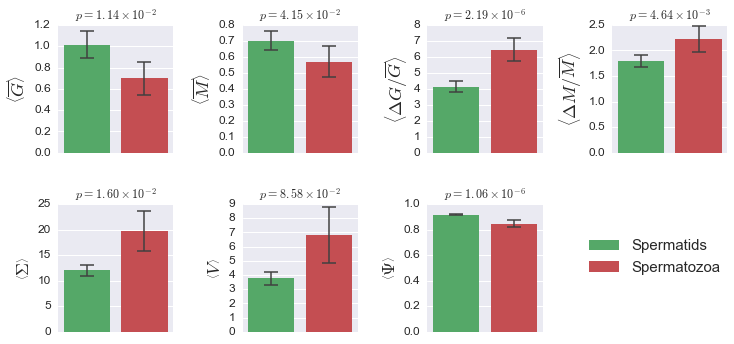

In [287]:
plt.figure(figsize=(12,5.5))
geno["hue"] = pheno.sample_type
yerrs = (1.96*geno.groupby(pheno.sample_type).std().T/np.sqrt(geno.groupby(pheno.sample_type).apply(lambda x:x.shape[0]))).T
for i,col in enumerate(geno.columns[:-1]):
    gax = plt.subplot(2,4,i+1)
    plt.title(latexformat(pvals[col]))
    sns.barplot(data=geno,x="hue",y=col,ax=gax,capsize=0,ci=0,
                palette=colors,linewidth=0,saturation=1,errcolor="0.25")
    plt.errorbar([0,1],
                 geno.groupby(pheno.sample_type).mean()[col].values,
                 # show std in errorbars
                 #yerr=geno.groupby(pheno.sample_type).std()[col].values,
                 # show 95% confidence for themean in errorbars
                 yerr=yerrs[col].values,
                 linewidth=0,elinewidth=1.5,capsize=7,capthick=1.5,color="0.25")
    # Fix ticks and labels
    plt.ylabel("$\\left\\langle"+col.replace("$","")+"\\right\\rangle$",fontsize=18)
    plt.yticks(fontsize=12)
    plt.xlabel("")
    plt.xticks([])
    
    # Draw legend
    if i==6:
        plt.bar([0],[0],linewidth=0,color=colors["Spermatids"],label="Spermatids")
        plt.bar([0],[0],linewidth=0,color=colors["Spermatozoa"],label="Spermatozoa")
        plt.legend(loc=(1.35,0.4),fontsize=15)
    
plt.subplots_adjust(wspace=0.6,hspace=0.4)
geno.drop("hue",axis=1,inplace=True)
plt.savefig("../output/figures/fig_barplots.pdf")


### Scatter plots
We can easily draw scatter plots of all-vs-all features using the seaborn.PairGrid function:

In [288]:
!open ../output/figures/fig_barplots.pdf

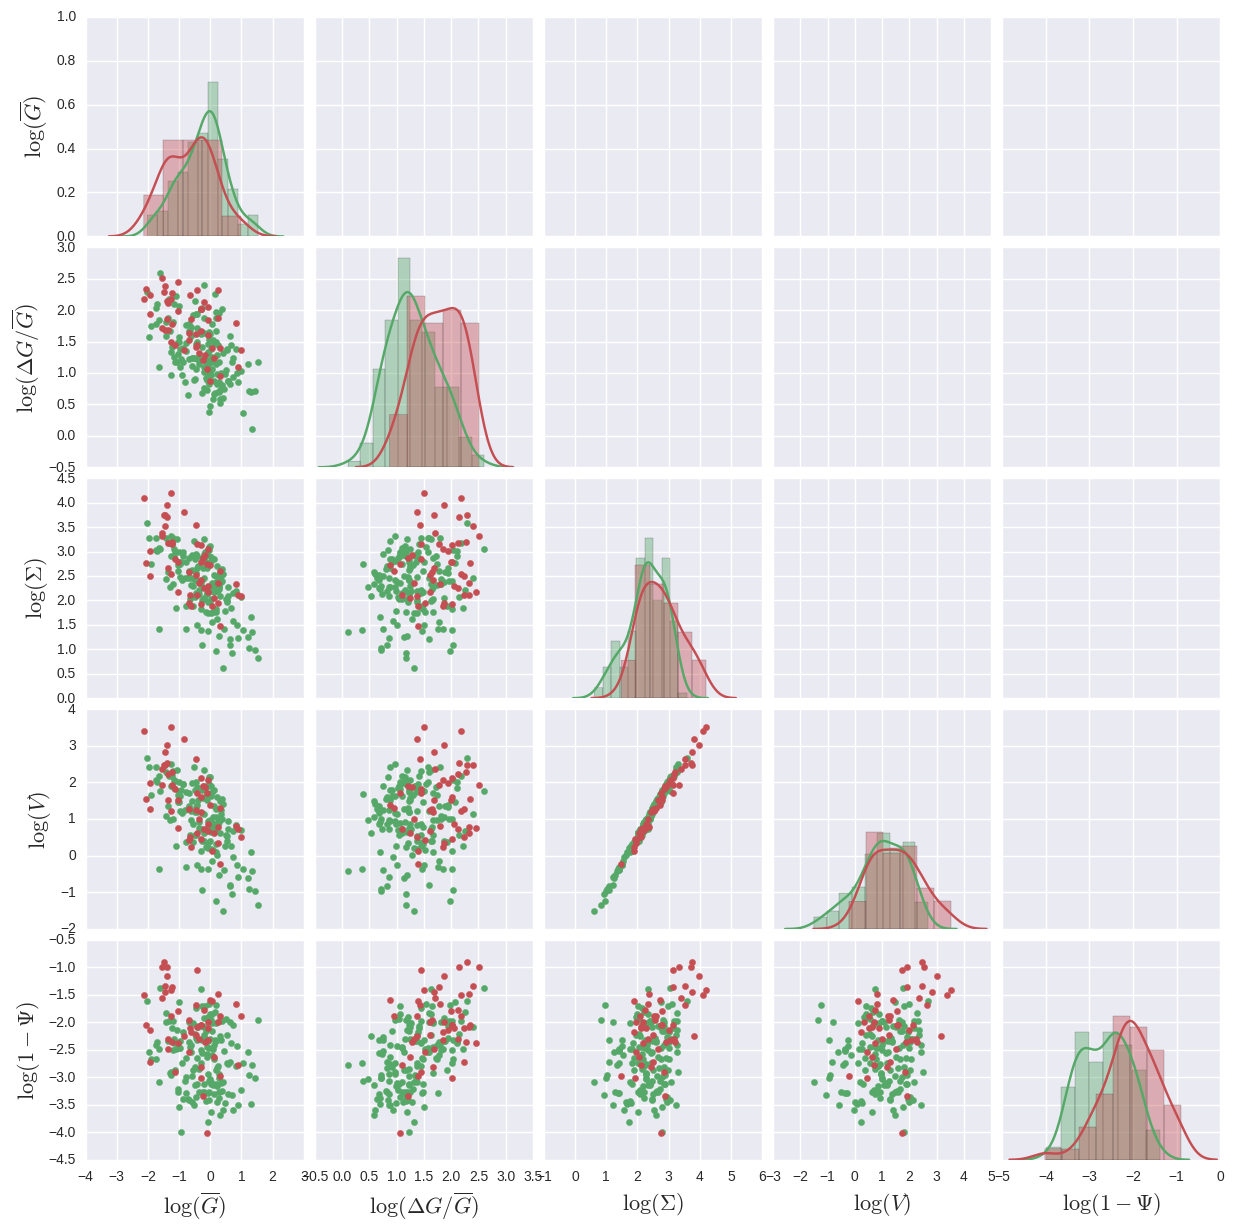

In [7]:
lgeno["sample_type"]=pheno.sample_type
g = sns.PairGrid(data=lgeno.iloc[:,[0,2,4,5,6,7]],hue="sample_type",palette=colors)
g.map_lower(plt.scatter,edgecolor=None,)
g.map_diag(sns.distplot)
lgeno.drop("sample_type",axis=1,inplace=True)

plt.subplots_adjust(hspace=0.05,wspace=0.05)
g.savefig("../output/figures/scatter_plots_bottom.pdf")

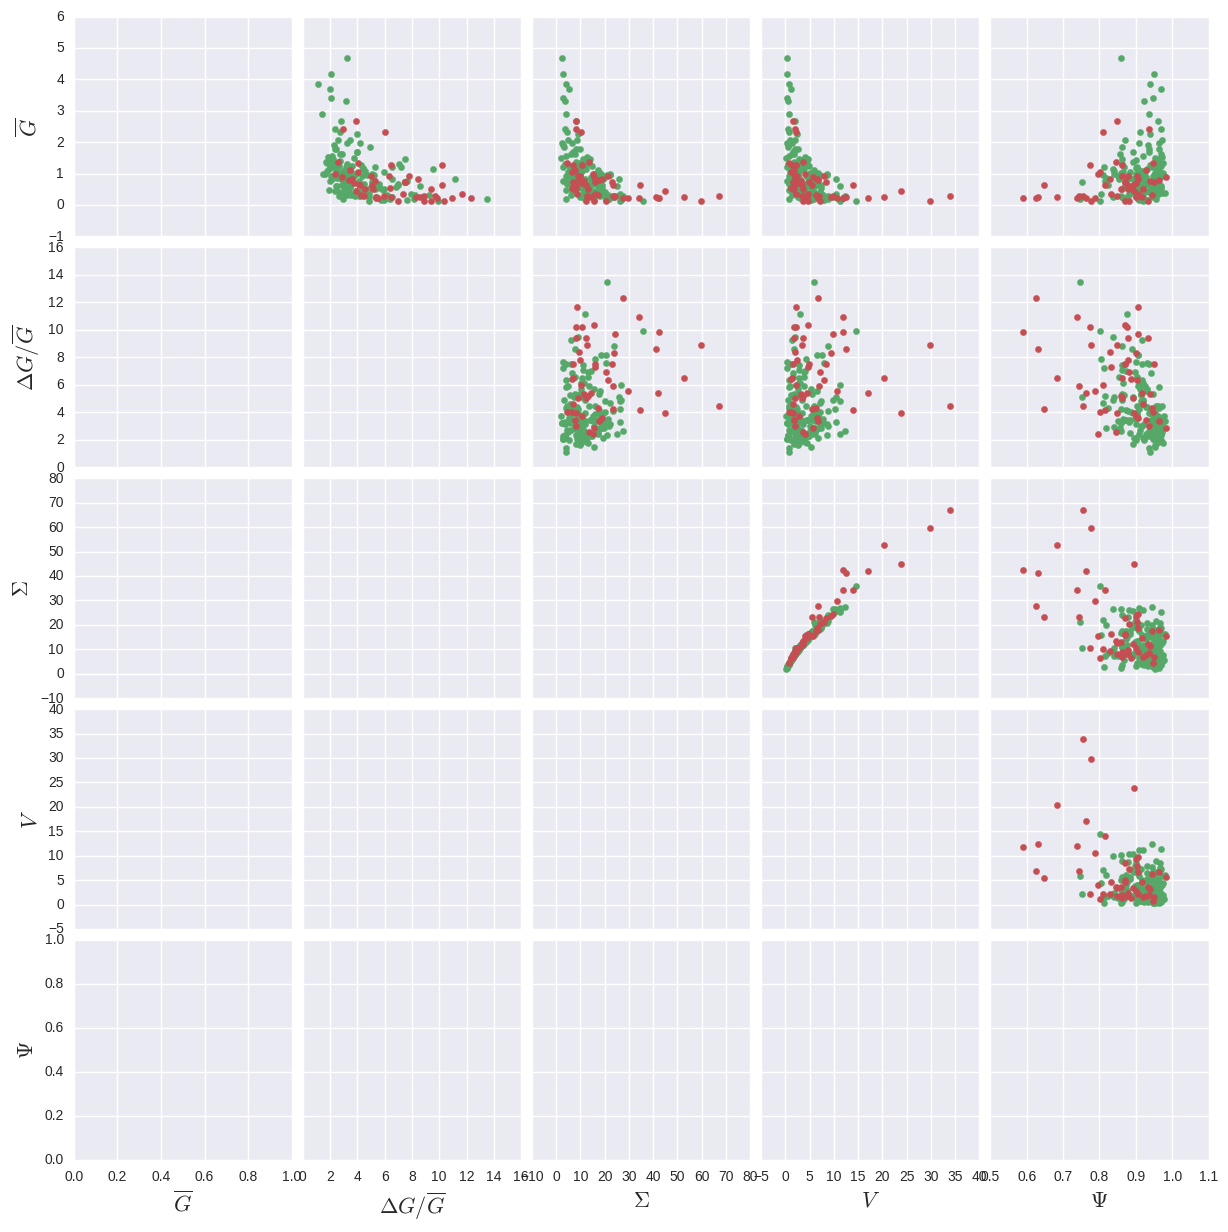

In [8]:
geno["sample_type"]=pheno.sample_type
h = sns.PairGrid(data=geno.iloc[:,[0,2,4,5,6,7]],hue="sample_type",palette=colors)
h.map_upper(plt.scatter,edgecolor=None)
geno.drop("sample_type",axis=1,inplace=True)

plt.subplots_adjust(hspace=0.05,wspace=0.05)
h.savefig("../output/figures/scatter_plots_top.pdf")

### Principal Component Analysis
A very popular visualization and dimensionality reduction technique is [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis). Here we see that no obvious clusters arise in a 2-dimensional projection onto the two first principal components.

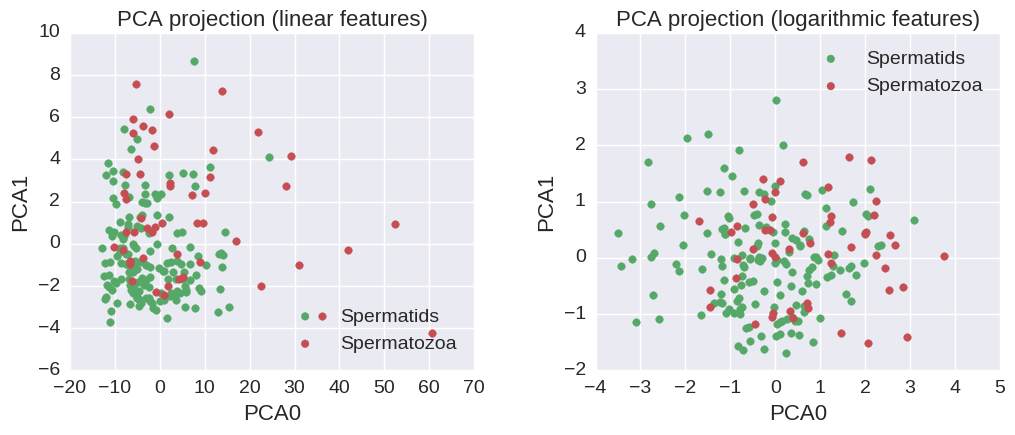

In [9]:
plt.figure(figsize=(12,4.5))

plt.subplot(121)
plt.title("PCA projection (linear features)",fontsize=16)
plt.xlabel("PCA0",fontsize=16)
plt.ylabel("PCA1",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
pca = PCA(n_components=2).fit_transform(geno)
t_geno = pd.DataFrame(index = geno.index,columns=["PCA0","PCA1"],data=pca)
for lab,df in t_geno.groupby(pheno.sample_type):
    plt.scatter(df.PCA0,df.PCA1,color=colors[lab],label=lab,s=30)
plt.legend(fontsize=14,loc=4)

plt.subplot(122)
plt.title("PCA projection (logarithmic features)",fontsize=16)
plt.xlabel("PCA0",fontsize=16)
plt.ylabel("PCA1",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
pca = PCA(n_components=2).fit_transform(lgeno)
t_geno = pd.DataFrame(index = lgeno.index,columns=["PCA0","PCA1"],data=pca)
for lab,df in t_geno.groupby(pheno.sample_type):
    plt.scatter(df.PCA0,df.PCA1,color=colors[lab],label=lab,s=30)
plt.legend(fontsize=14,loc=1)


plt.subplots_adjust(bottom=0.15,wspace=0.3)
plt.savefig("../output/figures/PCA_projection.pdf")
plt.show()

### Support Vector Machine
We will use a SVM with a linear kernel and 10-fold crossvalidation. We use our own implementation of cross-validation defined in [this file](../code/cross_validation.py).

In [10]:
import sys
sys.path.append("../code/")
from cross_validation import *

The data will be all 7 featurs in log space. We create codes for the sample types:

In [11]:
codes = {}
codes["Spermatids"]=0
codes["Spermatozoa"]=1
pheno["type_codes"] = pheno.sample_type.apply(lambda x:codes[x])
data = lgeno.values
target = pheno.type_codes.values

We run the classificaiton $N=1000$ times. We store results at the cell level, so that we can compute cell-specific accuracy values. 

In [12]:
n_runs = 1000

results = pd.DataFrame(columns=["run"+str(x) for x in range(n_runs)],index = geno.index)


clf = svm.SVC(kernel="linear",class_weight="balanced")

for run in range(n_runs):
    chosen = np.concatenate([np.random.choice(range(158),158,replace=False),np.random.choice(range(158,209),51,replace=False)])

    subdata = data[chosen]
    subtarget =target[chosen]

    # save results
    for i,b in enumerate(n_fold_cross_sklearn(subdata,subtarget,n=10,p=clf)[1]):
            results["run"+str(run)].iloc[chosen[i]] = b

In [13]:
# convert True,False to 1.,0.
results = results.astype(float)

In [22]:
cell_scores = results.mean(axis=1)
colors_cell = copy.deepcopy(cell_scores)
colors_cell.loc[pheno.sample_type=="Spermatozoa"] *= -1

Below we display the class-level accuracy scores and plot some of the figures in the manuscript:

In [15]:
print "Spermatids: %.0f%%" % (100*cell_scores.loc[pheno.sample_type=="Spermatids"].mean())
print "Spermatozoa: %.0f%%" % (100*cell_scores.loc[pheno.sample_type=="Spermatozoa"].mean())

Spermatids: 74%
Spermatozoa: 69%


In [16]:
import matplotlib.colors as mcolors
c = mcolors.ColorConverter().to_rgb

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

rvb = make_colormap(
    [colors["Spermatozoa"],c("white"),0.5,c("white"),colors["Spermatids"]])

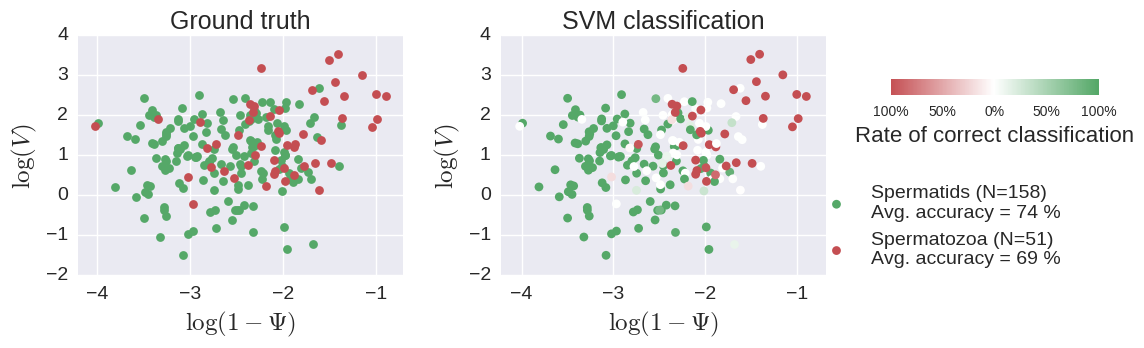

In [17]:
fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.title("Ground truth",fontsize=18)
plt.xticks(np.linspace(-4,-1,num=4),fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$\\log(1-\\Psi)$",fontsize=18)
plt.ylabel("$\\log(V)$",fontsize=18)
for lab,df in lgeno.groupby(pheno.sample_type):
    plt.scatter(df.iloc[:,6],df.iloc[:,5],
                c = colors[lab],
                linewidths=0,
                s=40,
                label=lab+" (N=%d)\nAvg. accuracy = %.0f %%" % (df.shape[0],100*np.abs(cell_scores.groupby(pheno.sample_type).mean())[lab])
            )
plt.legend(loc=(2.25,0),fontsize=14)

plt.subplot(122)
plt.title("SVM classification",fontsize=18)
plt.xticks(np.linspace(-4,-1,num=4),fontsize=14)
plt.yticks(fontsize=14)


plt.xlabel("$\\log(1-\\Psi)$",fontsize=18)
plt.ylabel("$\\log(V)$",fontsize=18)
plt.scatter(lgeno.iloc[:,6],lgeno.iloc[:,5],
            c = colors_cell,
            linewidths=0,
            s=40,
            cmap = rvb
           )

cbar_ax = fig.add_axes([0.75, 0.751, 0.16, 0.04]) # left,bottom,width,height
cbar = plt.colorbar(ticks=[-1,0,1],orientation="horizontal", cax=cbar_ax,drawedges=False)
cbar.solids.set_rasterized(True)
cbar.solids.set_edgecolor("face")

cbar.set_ticks([-1,-0.5,0,0.5,1])
cbar.set_ticklabels(["100%","50%","0%","50%","100%"])
cbar.set_label("Rate of correct classification")

plt.subplots_adjust(bottom=0.3,wspace=0.3,right=0.7)
plt.savefig("../output/figures/classification_scatter_accuracy.pdf")

In [18]:
def ratio_beyond_a(a,cell_scores):
    return sum(cell_scores>=a)/cell_scores.shape[0]

In [19]:
print "Average classification accuracy"
print "==="
print "All: %.0f%%" % (100*cell_scores.mean())
print "Spermatids: %.0f%%" % (100*cell_scores.loc[pheno.sample_type=="Spermatids"].mean())
print "Spermatozoa: %.0f%%" % (100*cell_scores.loc[pheno.sample_type=="Spermatozoa"].mean())

Average classification accuracy
===
All: 73%
Spermatids: 74%
Spermatozoa: 69%


In [20]:
print "Ratio of cells with high accuracy"
print "==="
for a in [0.85,0.99]:
    print "Accuracy beyond %.2f" % (a)
    print "    %s:%.2f"%("All",ratio_beyond_a(a,cell_scores=cell_scores))
    for lab in ["Spermatids","Spermatozoa"]:
        print "    %s:%.2f"%(lab,ratio_beyond_a(a,cell_scores=cell_scores.loc[pheno.sample_type==lab]))
    print

Ratio of cells with high accuracy
===
Accuracy beyond 0.85
    All:0.70
    Spermatids:0.72
    Spermatozoa:0.67

Accuracy beyond 0.99
    All:0.67
    Spermatids:0.69
    Spermatozoa:0.63



Finally, we save the predicted label of each cell, for each run of the algorithm, in a CSV file:

In [21]:
results.to_csv("../output/SVM_classification_full_results.csv")